### Implementación y Entrenamiento de una Red Neuronal Multicapa (MLP) para el Conjunto de Datos Digits

Este apartado detalla la configuración y el proceso de entrenamiento de una Red Neuronal Multicapa (MLP) para la clasificación de imágenes de dígitos manuscritos, utilizando el conjunto de datos `load_digits` de Scikit-learn. Se describe la preparación de los datos, la arquitectura del modelo, el bucle de entrenamiento y la evaluación del rendimiento.

Python 3.12.12
Mon Dec 15 21:24:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    1138MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------

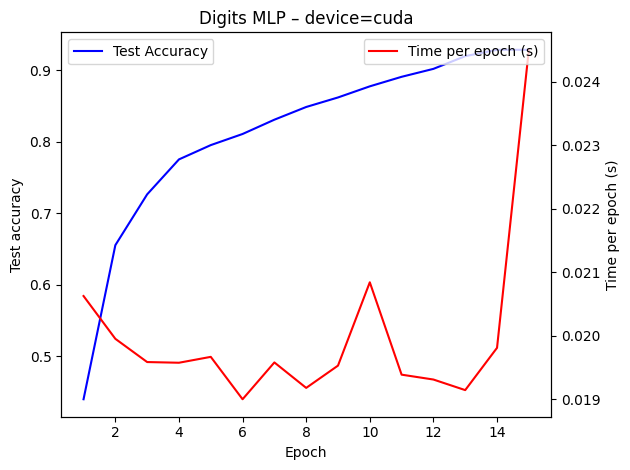

In [7]:
!python -V
!nvidia-smi

!pip -q install torch torchvision torchaudio matplotlib scikit-learn

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class MLP(nn.Module):
    def __init__(self, in_dim=64, hidden=128, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

def accuracy(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)

model = MLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 15
epoch_times = []
test_accs = []

# warmup
_ = model(X_train_t[:32].to(device))

lines = []
for ep in range(1, epochs + 1):
    t0 = time.perf_counter()
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

    model.eval()
    accs = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            accs.append(accuracy(logits, yb))
    acc = float(np.mean(accs))

    t1 = time.perf_counter()
    dt = t1 - t0
    epoch_times.append(dt)
    test_accs.append(acc)

    s = f"epoch {ep:02d}/{epochs} | test_acc={acc:.4f} | epoch_time_s={dt:.4f}"
    print(s)
    lines.append(s)

lines.append(f"FINAL: best_test_acc= {max(test_accs)}")
lines.append(f"FINAL: avg_epoch_time_s= {float(np.mean(epoch_times))}")
print(lines[-2])
print(lines[-1])

with open("run_gpu.txt", "w") as f:
    f.write("\n".join(lines) + "\n")

fig, ax1 = plt.subplots()
ax1.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', color='blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Test accuracy")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(1, epochs + 1), epoch_times, label='Time per epoch (s)', color='red')
ax2.set_ylabel("Time per epoch (s)")
ax2.legend(loc='upper right')

plt.title(f"Digits MLP – device={device.type}")
fig.tight_layout()
fig.savefig("train_curve_gpu.png", dpi=200)

print("Saved:", "run_gpu.txt", "train_curve_gpu.png")

### Resultados del Entrenamiento de la MLP para el Conjunto de Datos Digits

Tras el entrenamiento de la MLP, se observa una mejora constante en la precisión del modelo en el conjunto de prueba a lo largo de las épocas, alcanzando una precisión máxima de **0.9289**. El tiempo por época se estabiliza rápidamente después de la primera época de 'calentamiento'.

### Implementación y Entrenamiento de una Pequeña Red Neuronal Convolucional (CNN) para el Conjunto de Datos MNIST

Este apartado documenta la implementación de una Red Neuronal Convolucional (CNN) compacta para la clasificación de imágenes en el conjunto de datos MNIST. Se cubren los pasos de preprocesamiento de datos, la definición de la arquitectura de la CNN, el bucle de entrenamiento y la evaluación de la precisión del modelo.

Python 3.12.12
Mon Dec 15 21:22:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             31W /   70W |     806MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------

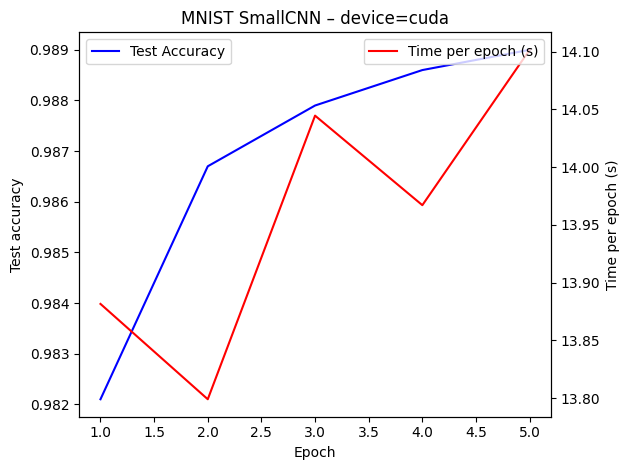

In [4]:
!python -V
!nvidia-smi

!pip -q install torch torchvision torchaudio matplotlib

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def eval_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=0)

model = SmallCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
epoch_times = []
test_accs = []

# warmup
xb0, _ = next(iter(train_loader))
_ = model(xb0[:32].to(device))

lines = []
for ep in range(1, epochs + 1):
    t0 = time.perf_counter()
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

    acc = eval_accuracy(model, test_loader, device)
    t1 = time.perf_counter()
    dt = t1 - t0

    epoch_times.append(dt)
    test_accs.append(acc)

    s = f"epoch {ep:02d}/{epochs} | test_acc={acc:.4f} | epoch_time_s={dt:.4f}"
    print(s)
    lines.append(s)

lines.append(f"FINAL: best_test_acc= {max(test_accs)}")
lines.append(f"FINAL: avg_epoch_time_s= {float(np.mean(epoch_times))}")
print(lines[-2])
print(lines[-1])

with open("run_mnist_gpu.txt", "w") as f:
    f.write("\n".join(lines) + "\n")

fig, ax1 = plt.subplots()
ax1.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', color='blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Test accuracy")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(1, epochs + 1), epoch_times, label='Time per epoch (s)', color='red')
ax2.set_ylabel("Time per epoch (s)")
ax2.legend(loc='upper right')

plt.title(f"MNIST SmallCNN – device={device.type}")
fig.tight_layout()
fig.savefig("train_curve_mnist_gpu.png", dpi=200)

print("Saved:", "run_mnist_gpu.txt", "train_curve_mnist_gpu.png")

### Resultados del Entrenamiento de la SmallCNN para el Conjunto de Datos MNIST

El entrenamiento de la SmallCNN en el conjunto de datos MNIST demuestra una alta eficacia, logrando una precisión máxima en el conjunto de prueba de **0.989**. El tiempo por época es consistente, indicando un proceso de entrenamiento eficiente.